In [164]:
from dotenv import load_dotenv
import os
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt


In [150]:
load_dotenv()

db_user = os.getenv('DB_USER')
db_pass = os.getenv('DB_PASS')
db_host = os.getenv('DB_HOST')
db_port = os.getenv('DB_PORT')
db_name = os.getenv('DB_NAME')

In [151]:
engine = create_engine(f"postgresql+psycopg2://{db_user}:{db_pass}@{db_host}:{db_port}/{db_name}")

In [152]:
# Helper function to sort rounds
def get_round_order(row):
    # Match regular rounds: 'R1', 'R23', etc.
    match = re.match(r'R(\d+)$', row['round'])
    if match:
        return int(match.group(1))
    # Finals rounds mapping (AFL convention)
    finals_order = {
        'REF': 100,  # Elimination Final (week 1)
        'RQF': 101,  # Qualifying Final (week 1)
        'RSF': 102,  # Semi Final (week 2)
        'RPF': 103,  # Preliminary Final (week 3)
        'RGF': 104,  # Grand Final (week 4)
    }
    code = row['round'][1:] 
    return finals_order.get(code, 999)  # Unknown finals get 999

In [153]:
# Calculate the average team age
query_age = """
SELECT 
    pgs.game_id, 
    pgs.team_id, 
    pgs.player_id, 
    p.birth_date, 
    g.game_date
FROM player_game_stats pgs
JOIN games g ON pgs.game_id = g.id
JOIN players p ON pgs.player_id = p.id
"""
df_players_age = pd.read_sql(query_age, engine)

df_players_age['age_at_game'] = (
    (pd.to_datetime(df_players_age['game_date']) - pd.to_datetime(df_players_age['birth_date'])).dt.days / 365.25
)

In [154]:
# Calculate per team, per game features
age_features = df_players_age.groupby(['game_id', 'team_id'])['age_at_game'].agg([
    ('average_team_age', 'mean'),
    ('median_team_age', 'median'),
    ('num_players_under_20', lambda x: (x < 20).sum()),
    ('num_players_20_to_23', lambda x: ((x >= 20) & (x < 23)).sum()),
    ('num_players_23_to_26', lambda x: ((x >= 23) & (x < 26)).sum()),
    ('num_players_26_to_28', lambda x: ((x >= 26) & (x < 28)).sum()),
    ('num_players_28_to_30', lambda x: ((x >= 28) & (x < 30)).sum()),
    ('num_players_30_plus', lambda x: (x >= 30).sum()),
    ('num_players_above_25', lambda x: (x >= 25).sum()),
    ('num_players_below_25', lambda x: (x < 25).sum()),
    ('num_players_above_26', lambda x: (x >= 26).sum()),
    ('num_players_below_26', lambda x: (x < 26).sum()),
    ('num_players_above_27', lambda x: (x >= 27).sum()),
    ('num_players_below_27', lambda x: (x < 27).sum()),
    ('num_players_above_28', lambda x: (x >= 28).sum()),
    ('num_players_below_28', lambda x: (x < 28).sum()),
    ('num_players_below_26_and_above_30', lambda x: ((x < 26) | (x >= 30)).sum()),
    ('num_players_below_20_and_above_30', lambda x: ((x < 20) | (x >= 30)).sum()),
]).reset_index()

In [155]:
# dataframe for games
df_games = pd.read_sql("SELECT * FROM games", engine)

In [156]:
# Get win/loss results

df_home_result = df_games[['id', 'season_year', 'round', 'home_team_id', 'home_result']]
df_home_result = df_home_result.rename(columns={
    'id': 'game_id',
    'home_team_id': 'team_id',
    'home_result': 'result'
})
df_home_result['home_or_away'] = 'home'

df_away_result = df_games[['id', 'season_year', 'round', 'away_team_id', 'away_result']]
df_away_result = df_away_result.rename(columns={
    'id': 'game_id',
    'away_team_id': 'team_id',
    'away_result': 'result'
})
df_away_result['home_or_away'] = 'away'

df_results = pd.concat([df_home_result, df_away_result], ignore_index=True)

In [157]:
# Merge results

age_features = age_features.merge(df_results, on=['game_id', 'team_id'])

age_features['result_num'] = age_features['result'].map({'W': 1, 'L': 0, 'D': 0.5})

# for logistic analysis, remove draws
age_features = age_features[age_features['result'] != 'D'].copy()

average_team_age      0.3786
median_team_age       0.2589
num_players_under_20 -0.2614
num_players_20_to_23 -0.1074
num_players_23_to_26  0.0296
num_players_26_to_28  0.1005
num_players_28_to_30  0.1598
num_players_30_plus   0.0897
num_players_above_25  0.1195
num_players_below_25 -0.1280
num_players_above_26  0.1204
num_players_below_26 -0.1285
num_players_above_27  0.1133
num_players_below_27 -0.1220
num_players_above_28  0.1156
num_players_below_28 -0.1255
num_players_below_26_and_above_30 -0.1364
num_players_below_20_and_above_30 -0.0604


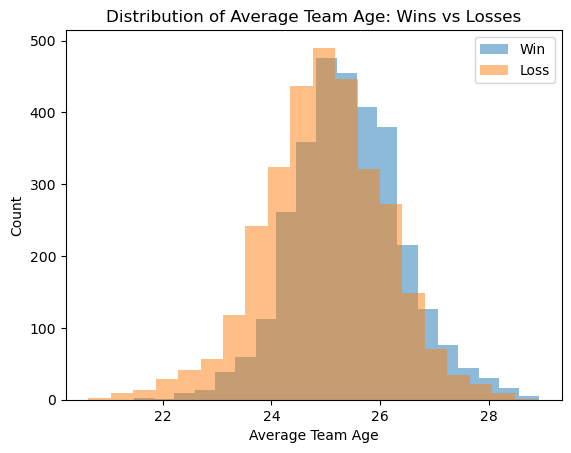

In [159]:
# logistic regression

features = [
    'average_team_age', 
    'median_team_age',
    'num_players_under_20', 
    'num_players_20_to_23', 
    'num_players_23_to_26', 
    'num_players_26_to_28', 
    'num_players_28_to_30', 
    'num_players_30_plus',
    'num_players_above_25', 
    'num_players_below_25',
    'num_players_above_26',
    'num_players_below_26',
    'num_players_above_27', 
    'num_players_below_27',
    'num_players_above_28', 
    'num_players_below_28',
    'num_players_below_26_and_above_30',
    'num_players_below_20_and_above_30'
]
for feature in features:
    X = age_features[[feature]]
    y = age_features['result_num']

    model = LogisticRegression()
    model.fit(X, y)
    coef = model.coef_[0][0]
    print(f"{feature:20s} {coef: .4f}")

plt.hist(age_features[age_features['result_num'] == 1]['average_team_age'], bins=20, alpha=0.5, label='Win')
plt.hist(age_features[age_features['result_num'] == 0]['average_team_age'], bins=20, alpha=0.5, label='Loss')
plt.xlabel('Average Team Age')
plt.ylabel('Count')
plt.title('Distribution of Average Team Age: Wins vs Losses')
plt.legend()
plt.show()

Linear coef: 2.5462
Quadratic coef: -0.0431
Intercept: -36.7691
Accuracy: 57.443%
AUC: 0.610


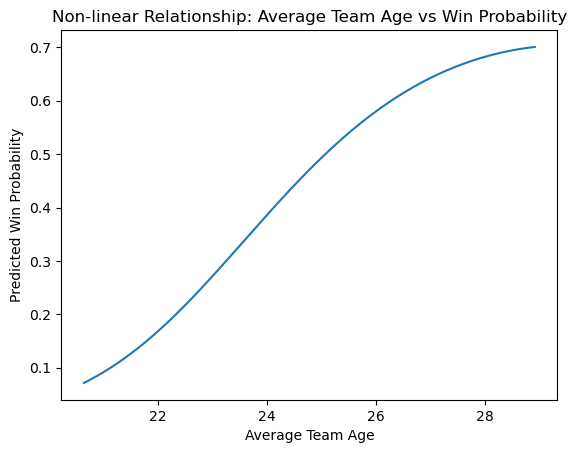

In [165]:
# Check for quadratic relationship
age_features['average_team_age_sq'] = age_features['average_team_age'] ** 2

# Fit logistic regression with both linear and quadratic terms
X = age_features[['average_team_age', 'average_team_age_sq']]
y = age_features['result_num']

model = LogisticRegression()
model.fit(X, y)
print(f"Linear coef: {model.coef_[0][0]:.4f}")
print(f"Quadratic coef: {model.coef_[0][1]:.4f}")
print(f"Intercept: {model.intercept_[0]:.4f}")

# Predict probabilities on training data
train_probs = model.predict_proba(X)[:, 1]
train_preds = (train_probs > 0.5).astype(int)

# Accuracy and AUC
accuracy = accuracy_score(y, train_preds)
auc = roc_auc_score(y, train_probs)
print(f"Accuracy: {accuracy:.3%}")
print(f"AUC: {auc:.3f}")

# Create range of ages to predict on
ages = np.linspace(age_features['average_team_age'].min(), age_features['average_team_age'].max(), 200)
ages_sq = ages ** 2
X_pred = pd.DataFrame({
    'average_team_age': ages,
    'average_team_age_sq': ages_sq
})
probs = model.predict_proba(X_pred)[:, 1]

plt.plot(ages, probs)
plt.xlabel("Average Team Age")
plt.ylabel("Predicted Win Probability")
plt.title("Non-linear Relationship: Average Team Age vs Win Probability")
plt.show()



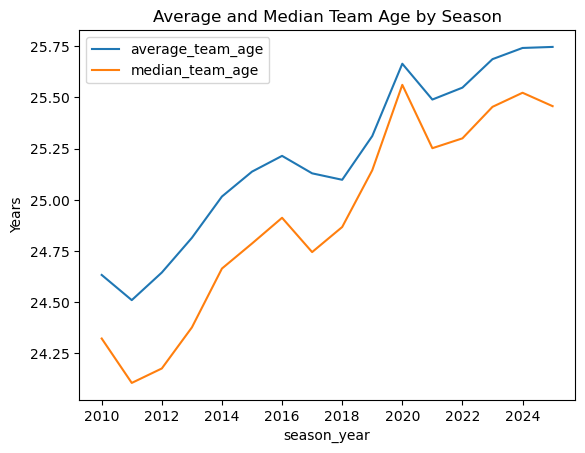

In [ ]:
age_features.groupby('season_year')[['average_team_age', 'median_team_age']].mean().plot()
plt.title('Average and Median Team Age by Season')
plt.ylabel('Years')
plt.show()

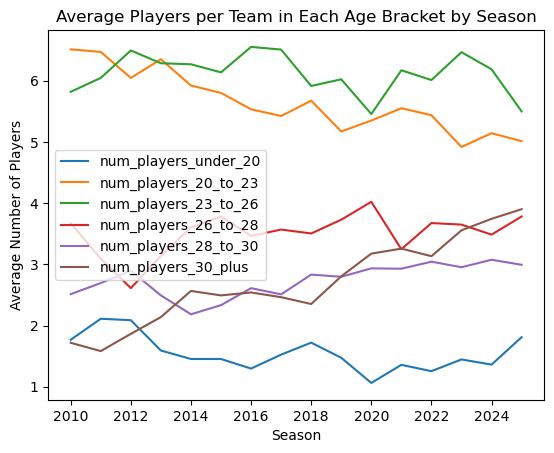

In [ ]:
bracket_cols = [
    'num_players_under_20', 
    'num_players_20_to_23', 
    'num_players_23_to_26', 
    'num_players_26_to_28', 
    'num_players_28_to_30', 
    'num_players_30_plus'
]
brackets_by_year = age_features.groupby('season_year')[bracket_cols].mean()
brackets_by_year.plot()
plt.title('Average Players per Team in Each Age Bracket by Season')
plt.ylabel('Average Number of Players')
plt.xlabel('Season')
plt.show()

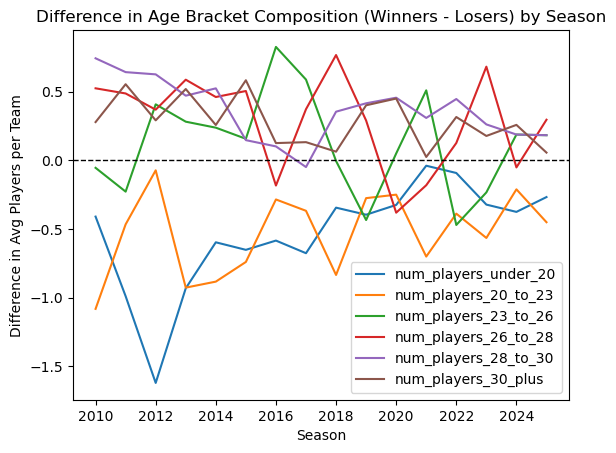

In [ ]:
winners = age_features[age_features['result'] == 'W']
win_age_trends = winners.groupby('season_year')[bracket_cols].mean()

losers = age_features[age_features['result'] == 'L']
lose_age_trends = losers.groupby('season_year')[bracket_cols].mean()

(wins_minus_losses := win_age_trends - lose_age_trends).plot()
plt.title('Difference in Age Bracket Composition (Winners - Losers) by Season')
plt.ylabel('Difference in Avg Players per Team')
plt.xlabel('Season')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.show()

In [ ]:
# Figure out if older team won
game_teams = age_features[['game_id', 'team_id', 'average_team_age', 'result']]
pairs = game_teams.merge(game_teams, on='game_id', suffixes=('_1', '_2'))
# Only keep pairs where team_id_1 < team_id_2 to avoid double counting
pairs = pairs[pairs['team_id_1'] < pairs['team_id_2']]
def older_team_wins(row):
    if row['average_team_age_1'] > row['average_team_age_2']:
        return row['result_1'] == 'W'
    else:
        return row['result_2'] == 'W'

pairs['older_team_won'] = pairs.apply(older_team_wins, axis=1)
correct = pairs['older_team_won'].sum()
total = pairs['older_team_won'].notnull().sum()
print(f"Accuracy if always pick the older team: {correct}/{total} = {correct/total:.1%}")



Accuracy if always pick the older team: 1946/3090 = 63.0%
